In [1]:
import numpy as np

# Simulation parameters
N = 100         # Grid size
dt = 0.1        # Time step
diff = 0.0      # Diffusion rate
visc = 0.0001   # Viscosity

def set_bnd(b, x):
    N = x.shape[0]-2
    for i in range(1, N+1):
        x[0, i] = -x[1, i] if b == 1 else x[1, i]
        x[N+1, i] = -x[N, i] if b == 1 else x[N, i]
        x[i, 0] = -x[i, 1] if b == 2 else x[i, 1]
        x[i, N+1] = -x[i, N] if b == 2 else x[i, N]
    x[0, 0] = 0.5 * (x[1, 0] + x[0, 1])
    x[0, N+1] = 0.5 * (x[1, N+1] + x[0, N])
    x[N+1, 0] = 0.5 * (x[N, 0] + x[N+1, 1])
    x[N+1, N+1] = 0.5 * (x[N, N+1] + x[N+1, N])

def add_source(x, s, dt):
    x += dt * s

def diffuse(b, x, x0, diff, dt):
    N = x.shape[0]-2
    a = dt * diff * N * N
    for k in range(20):
        x[1:N+1,1:N+1] = (x0[1:N+1,1:N+1] + a * (x[0:N,1:N+1] + x[2:N+2,1:N+1] +
                             x[1:N+1,0:N] + x[1:N+1,2:N+2])) / (1 + 4 * a)
        set_bnd(b, x)

def advect(b, d, d0, u, v, dt):
    N = d.shape[0]-2
    dt0 = dt * N
    X, Y = np.meshgrid(np.arange(1, N+1), np.arange(1, N+1), indexing='ij')
    x = X - dt0 * u[1:N+1,1:N+1]
    y = Y - dt0 * v[1:N+1,1:N+1]

    x = np.clip(x, 0.5, N + 0.5)
    y = np.clip(y, 0.5, N + 0.5)

    i0 = x.astype(int)
    i1 = i0 + 1
    j0 = y.astype(int)
    j1 = j0 + 1

    s1 = x - i0
    s0 = 1 - s1
    t1 = y - j0
    t0 = 1 - t1

    i0 = np.clip(i0, 0, N+1)
    i1 = np.clip(i1, 0, N+1)
    j0 = np.clip(j0, 0, N+1)
    j1 = np.clip(j1, 0, N+1)

    d[1:N+1,1:N+1] = (
        s0 * (t0 * d0[i0, j0] + t1 * d0[i0, j1]) +
        s1 * (t0 * d0[i1, j0] + t1 * d0[i1, j1])
    )
    set_bnd(b, d)

def project(u, v, p, div):
    N = u.shape[0]-2
    div[1:N+1,1:N+1] = -0.5 * (u[2:N+2,1:N+1] - u[0:N,1:N+1] +
                                v[1:N+1,2:N+2] - v[1:N+1,0:N]) / N
    p.fill(0)
    set_bnd(0, div)
    set_bnd(0, p)
    for k in range(50):
        p[1:N+1,1:N+1] = (div[1:N+1,1:N+1] + p[0:N,1:N+1] + p[2:N+2,1:N+1] +
                          p[1:N+1,0:N] + p[1:N+1,2:N+2]) / 4
        set_bnd(0, p)
    u[1:N+1,1:N+1] -= 0.5 * N * (p[2:N+2,1:N+1] - p[0:N,1:N+1])
    v[1:N+1,1:N+1] -= 0.5 * N * (p[1:N+1,2:N+2] - p[1:N+1,0:N])
    set_bnd(1, u)
    set_bnd(2, v)

def vel_step(u, v, u0, v0, visc, dt):
    add_source(u, u0, dt)
    add_source(v, v0, dt)
    u0[:,:], u[:,:] = u.copy(), u0.copy()
    v0[:,:], v[:,:] = v.copy(), v0.copy()
    diffuse(1, u, u0, visc, dt)
    diffuse(2, v, v0, visc, dt)
    project(u, v, u0, v0)
    u0[:,:], u[:,:] = u.copy(), u0.copy()
    v0[:,:], v[:,:] = v.copy(), v0.copy()
    advect(1, u, u0, u0, v0, dt)
    advect(2, v, v0, u0, v0, dt)
    project(u, v, u0, v0)

def dens_step(x, x0, u, v, diff, dt):
    add_source(x, x0, dt)
    x0[:,:], x[:,:] = x.copy(), x0.copy()
    diffuse(0, x, x0, diff, dt)
    x0[:,:], x[:,:] = x.copy(), x0.copy()
    advect(0, x, x0, u, v, dt)

# Initialize simulation arrays
size = N+2
u = np.zeros((size, size))
v = np.zeros((size, size))
u_prev = np.zeros((size, size))
v_prev = np.zeros((size, size))
dens = np.zeros((size, size))
dens_prev = np.zeros((size, size))

def update(frame):
    global u, v, u_prev, v_prev, dens, dens_prev

    # Clear previous sources
    dens_prev.fill(0)
    u_prev.fill(0)
    v_prev.fill(0)

    # Complex source distribution
    t = frame * dt
    num_sources = 5
    angles = np.linspace(0, 2*np.pi, num_sources, endpoint=False) + t * 0.1
    radius = N // 4
    cx, cy = N // 2, N // 2
    for angle in angles:
        x_pos = int(cx + radius * np.cos(angle))
        y_pos = int(cy + radius * np.sin(angle))
        if 1 <= x_pos < N+1 and 1 <= y_pos < N+1:
            dens_prev[x_pos, y_pos] = 200
            u_prev[x_pos, y_pos] = 50 * np.cos(angle)
            v_prev[x_pos, y_pos] = 50 * np.sin(angle)

    vel_step(u, v, u_prev, v_prev, visc, dt)
    dens_step(dens, dens_prev, u, v, diff, dt)
    

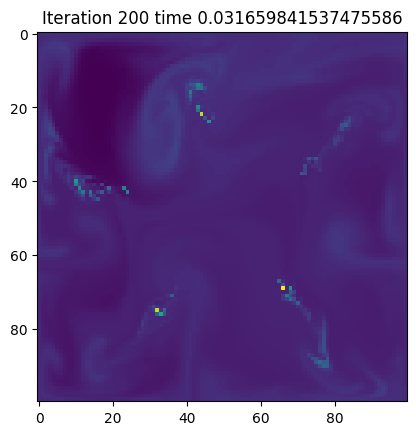

In [ ]:
%matplotlib inline

import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

for i in range(200):

    start_time = time.time()
    update(i)
    processing_time = time.time() - start_time
    
    clear_output(wait=True)
    plt.imshow(dens)
    plt.title(f"Iteration {i+1} time {processing_time}")
    plt.show()

    